In [117]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [118]:
class Encoder(nn.Module):
    def __init__(self,im_chan=3,output_chan=128,hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim=output_chan
        self.enc=nn.Sequential(
            self.make_enc_block(im_chan,hidden_dim),
            self.make_enc_block(hidden_dim,hidden_dim*2),
            self.make_enc_block(hidden_dim*2,hidden_dim*4),
            self.make_enc_block(hidden_dim*4,hidden_dim*8),
            self.make_enc_block(hidden_dim * 8, hidden_dim * 8),
            self.make_enc_block(hidden_dim*8,2*output_chan,kernel_size=4,stride=1,padding=0,final_layer=True)
        )
        
    def make_enc_block(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1,final_layer=False):
        if not final_layer:
            return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True),
            )
        else:
            return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
            )
    
    def forward(self,x):
        x=self.enc(x)
        enc=x.view(len(x),-1)
#         print(enc.shape)
        return enc[:,:self.z_dim],enc[:,self.z_dim:].exp()
    

    
        

In [119]:
class Decoder(nn.Module):
    def __init__(self, z_dim=128, im_chan=3, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen=nn.Sequential(
        self.make_gen_block(z_dim,hidden_dim*8,kernel_size=4,stride=1,padding=0), # ch x 4 x4
        self.make_gen_block(hidden_dim * 8,hidden_dim * 4,kernel_size=4,stride=2,padding=1),  #ch x 8 x8
        self.make_gen_block(hidden_dim * 4,hidden_dim*2,kernel_size=4,stride=2,padding=1), # ch x 16 x 16
        self.make_gen_block(hidden_dim * 2,hidden_dim*1,kernel_size=4,stride=2,padding=1), # ch x 32 x 32
        self.make_gen_block(hidden_dim * 1,hidden_dim*1,kernel_size=4,stride=2,padding=1), # ch x 64 x 64
        self.make_gen_block(hidden_dim,im_chan,kernel_size=4,stride=2,padding=1,final_layer=True), # 128 X 128
        )
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2,padding=0,final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding),
                nn.Tanh(),
            )
    def forward(self, noise):
       
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    

In [120]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    def __init__(self,z_dim=128,im_chan=3,hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim=z_dim
        self.encoder=Encoder(im_chan,z_dim)
        self.decoder=Decoder(z_dim,im_chan)
        
    def forward(self,images):
        mean,std=self.encoder(images)
#         print(torch.cat((mean[0].detach(),std[0].detach()),dim=0))
        dist=Normal(mean,std)
        z=dist.rsample()
        decoding=self.decoder(z)
        
        return decoding,dist

In [131]:
def show_tensor_images(image_tensor,num_images=10,size=(3,128,128),nrow=5):
    image_tensor=(image_tensor+1)/2
    image_unflat=image_tensor.detach().cpu()
    image_grid=make_grid(image_unflat[:num_images],nrow=nrow)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
#     plt.show()
plt.rcParams["figure.figsize"]=(32,16)

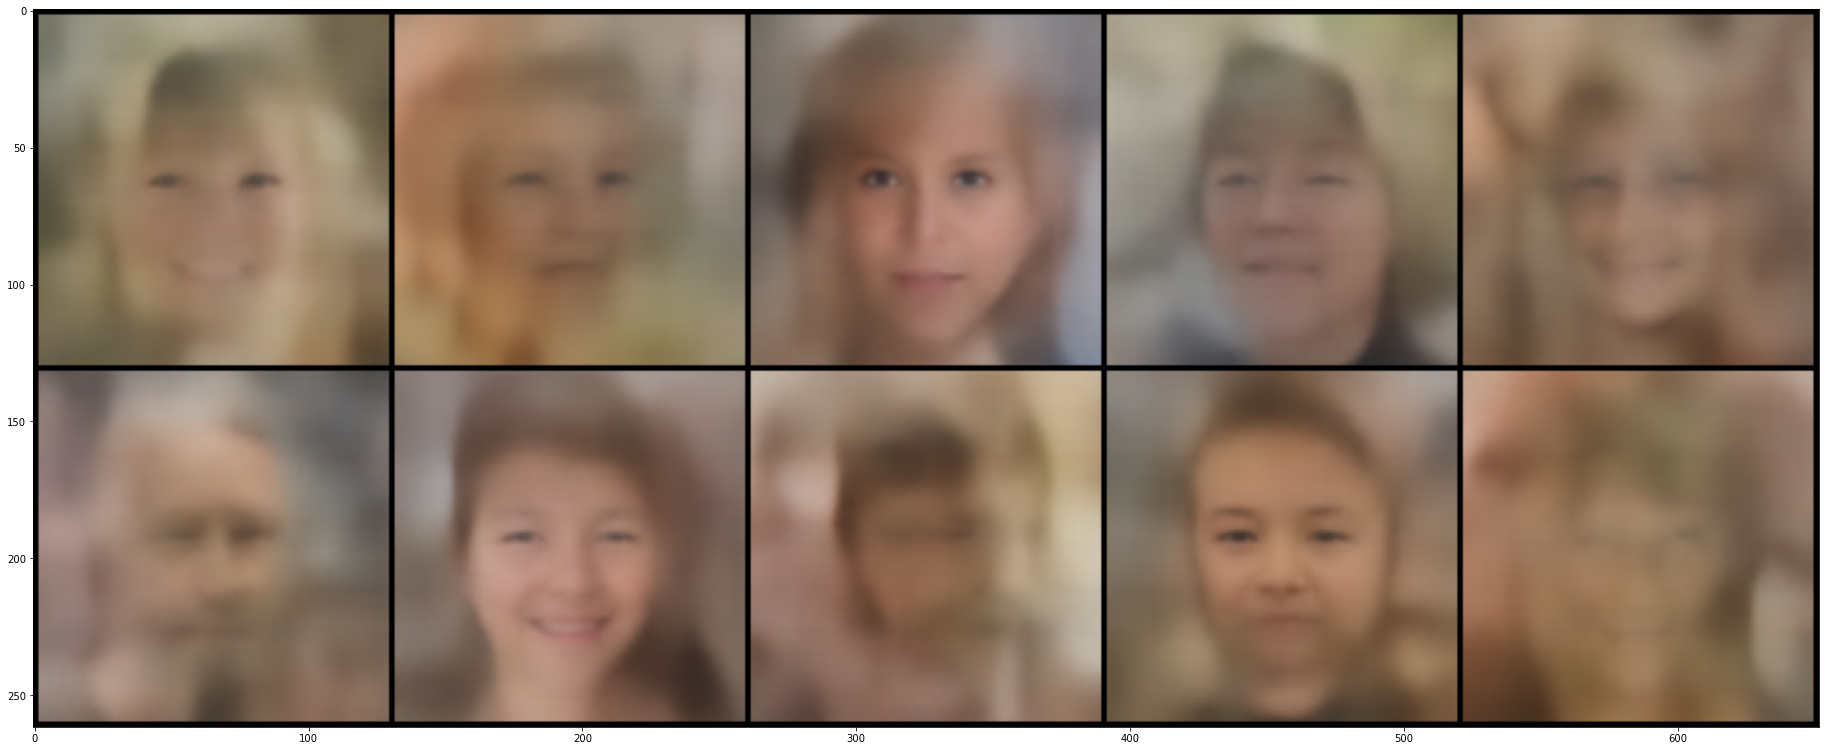

In [149]:
gen=Decoder()
gen.load_state_dict(torch.load("vae_decoder.pth"))
gen.eval()
# z=torch.randn(10,128)
z=torch.normal(mean=0,std=1,size=(10,128))
images=gen(z)
show_tensor_images(images)


In [138]:
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

batch_size=64

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((128,128))
])

data=ImageFolder(root="P:/dataset/celeba/",transform=transform)
dataloader=DataLoader(dataset=data,batch_size=batch_size,shuffle=True,num_workers=4,persistent_workers=True)

In [151]:
vae=VAE()
vae.load_state_dict(torch.load("vae.pth"))
vae.eval()

VAE(
  (encoder): Encoder(
    (enc): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

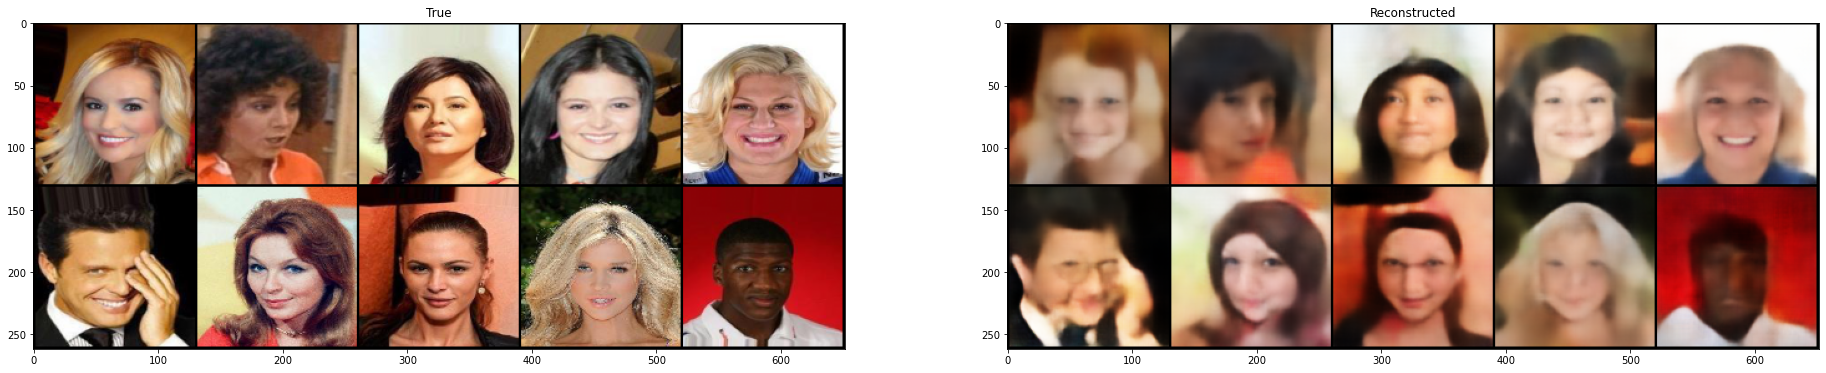

In [152]:
x,_=next(iter(dataloader))
recon_images,_=vae(x)
plt.subplot(1,2,1)
show_tensor_images(x)
plt.title("True")
plt.subplot(1,2,2)
show_tensor_images(recon_images)
plt.title("Reconstructed")
plt.show()


In [137]:
x.shape

torch.Size([64, 3, 128, 128])